# Big Data in Finance
## Part IV: CRSP and Compustat
### Homework I: Due March 25, 2021, by 11:59 pm.


**Goal**: Explore the information CRSP and Compustat

**Delivery**: Please, upload on canvas a .zip file with your .ipynb and .html notebook. 


# Description

The year of 2020 was remarkable for U.S. stock market investors. The S&P 500-stock index, the most widely watched gauge, is finishing the year up more than 16 percent. The Dow Jones industrial average and the tech-heavy Nasdaq gained 7.25 percent and 43.6 percent, respectively. The Dow and S&P 500 finished at record levels despite the public health and economic crises.

Let's look by what has happened with stock returns using the data downloaded from CRSP and Compustat .

1. What was the cumulative average (market-cap weighted) returns of CRSP stocks in the year 2020? Plot the cumulative monthly returns and report how much an investor would have the by end-December 2020, had she invested $1 in the CRSP stocks in beginning of January 2020. How much would the same investor have had she entered the market in end-March, during the months oh highest stock volatility? Some things to be aware:

    a. You should only consider ordinary common stocks, i.e., shrcd equal to 10 or 11.
    
    b. You should only consider stocks listed in one of the three main stock exchanges, i.e., exchcd equal to 1 (NYSE), 2 (NYSE MKT) or 3 (NASDAQ). 


2. How much an investor would have by end-December 2020, had he invested $1 in a tech-stocks portfolio in beginning of January 2020? Plot the cumulative returns. What are the 10-top performance stocks in the year of 2020? Some things to be aware:

    a. The closest definition of Tech firms according to Fama and French is Business Equipment industry, which includes Computers, Software, and Electronic Equipment. These are firms with SIC codes in the following ranges:
          3570-3579
          3660-3692
          3694-3699
          3810-3829
          7370-7379
          
    b. To calculate the monthly returns of the tech industry, remember to value-weight returns according to market cap. 


3. Are the tech stocks with the highest returns the ones that realized highest profits in 2020? Use operating profitability normalized by book-equity (OPBE) from the lecture notes as a measure of profitability. Select the 10-top profits in the tech industry in 2020. Are they the same stocks you selected in the previous question? Was the result you expected? 


# Code 

## Packages

Below you have some code that should help you to get started. Make sure you have installed all required packages. Use "conda install"  or "pip install" if you you are missing any of the packages.

In [1]:
# Packages
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wrds

# Setups
pd.set_option("display.max_rows", 100)

##   WRDS Connection

Make sure you can connect to WRDS server. You should configure wrds connector before hand. Please check the syllabus for details.


In [2]:
# Set Up WRDS connection
db = wrds.Connection(wrds_username='lmota') # make sure to change the username. 

Loading library list...
Done


## Determine the libraries available at WRDS

In [3]:
# # List all libraries in WRDS
# libs = db.list_libraries()
# libs.__class__ # Notice that libs is a list. 
# pd.DataFrame({'libraries':libs}).sort_values('libraries') # Transform libs to a Pandas data frame to have a better display.

 ## Determine the datasets within a given library

In [4]:
# compd_tables = db.list_tables(library="comp") # compd: Compustat daily update
# pd.DataFrame({'tables':compd_tables}) # Transform libs to a Pandas data frame to have a better display.

 ## Determine the column headers (variables) within a given dataset

In [5]:
# db.describe_table(library="comp", table="funda")

## Example of submitting a SQL query to import data

In [6]:
# comp = db.raw_sql('SELECT datadate, fyear, gvkey, conm, at, ebit, che FROM compm.funda LIMIT 10;', date_cols=['datadate'])
# comp

## Q1 -- CRSP Stock Returns

### Download MSF

In [3]:
sfvars = ['prc','vol','ret', 'retx','cfacpr','cfacshr']
query = """SELECT date, permno, permco, {} 
           FROM crsp.msf
           WHERE date>='2019-12-01'""".format(', '.join(sfvars))
msf_data = db.raw_sql(query, date_cols=['date'])

# check PK
assert msf_data.duplicated(subset=['date','permno']).sum() == 0

#### Download MSEALL

In [4]:
msevars = ['comnam', 'dlret', 'dlretx', 'exchcd','naics', 'cusip', 'ncusip', 'shrcd', 'shrout', 
           'siccd', 'ticker']
query = """SELECT date, permno, permco, {} 
           FROM crspq.mseall
           WHERE date>='2019-12-01'""".format(', '.join(msevars))
mse_data = db.raw_sql(query, date_cols=['date'])

# drop duplicates
mse_data = mse_data[~mse_data.duplicated()].copy()

# check PK
assert mse_data.duplicated(subset=['date','permno']).sum() == 0

#### Merge MSF and MSEALL

In [5]:
# sort
msf_data.sort_values(['date', 'permno'], inplace=True)
mse_data.sort_values(['date', 'permno'], inplace=True)

# Check of coverage
x = pd.Series(msf_data.permno.unique())
y = pd.Series(mse_data.permno.unique())
assert len(x[~x.isin(y)]) == 0

# Check if delisting happens only once per security
assert mse_data[mse_data.dlret.notnull()].groupby(['permno']).date.value_counts().max() == 1

# Check if delisting returns only appears after the firm is not longer covered by msf
test = mse_data[mse_data.dlret.notnull()]
test = pd.merge(msf_data, test[['permno', 'dlret', 'date']], on=['permno'])
assert len(test[test.date_x>test.date_y]) == 0

In [6]:
crsp = pd.merge_asof(msf_data, 
                     mse_data, 
                     on='date', 
                     by=['permno','permco'], 
                     direction='backward')

# Check Primary Key
assert crsp.duplicated(subset=['permno','date']).sum() == 0

In [7]:
#crsp.head()

#### Adjust returns for stock delisting

In [8]:
crsp['retadj'] = ((1+crsp['ret'].fillna(0))*(1+crsp['dlret'].fillna(0))-1)
crsp.loc[crsp[['ret', 'dlret']].isnull().all(axis=1), 'retadj'] = np.nan

#### Calculate market value of equity

In [9]:
# SHROUT is the number of publicly held shares, recorded in thousands. ME will be reported in 1,000,000 ($10^6$),
# Like on Ken French's website. 
crsp['me'] = abs(crsp['prc']) * (crsp['shrout']/1000)

# If the stock is delisted, we set ME to NaN.
crsp.loc[crsp.dlret.notnull(), 'me'] = np.nan

#### Lagged ME

In [10]:
# lag one month for value weighting
crsp.sort_values(['permno','date'], inplace=True)
crsp['melag_nt']=crsp.groupby(['permno']).me.shift(1)

# TODO: Check for skipping
# What to do if ME is missing? We pad for the lattest available info
crsp['melag'] = crsp.groupby('permno').melag_nt.fillna(method='pad')

# keep 2020 data
crsp = crsp[crsp['date'] >= '2020-01-01']

#### Apply Filters

In [11]:
crsp = crsp.loc[(crsp['shrcd'] == 11) | (crsp['shrcd'] == 10)].copy()
crsp = crsp.loc[(crsp['exchcd'] == 1) | (crsp['exchcd'] == 2) | (crsp['exchcd'] == 3)].copy()

#### Cumulative returns

In [30]:
crsp.sort_values(by=['permno', 'date'], ascending=True, inplace=True)
crsp = crsp[crsp.melag.notnull()]
crsp = crsp[crsp.retadj.notnull()]
crsp['cum_ret'] = crsp.groupby('permno')['retadj'].apply(lambda x: (1 + x).cumprod())

#### CRSP value weighted returns

<AxesSubplot:xlabel='date'>

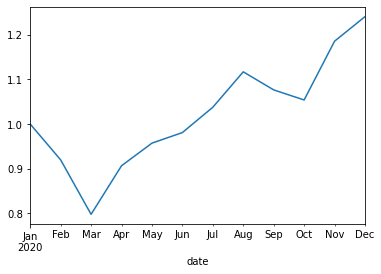

In [31]:
ret_w = crsp.groupby('date').apply(lambda x: np.average(x['retadj'], weights = x['melag']))
(1 + ret_w).cumprod().plot()

#### CRSP equal weighted returns

<AxesSubplot:xlabel='date'>

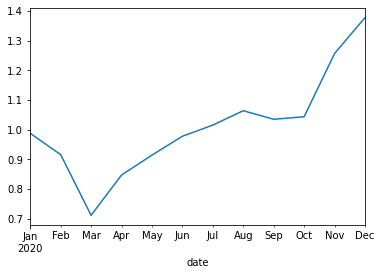

In [32]:
(1+crsp.groupby('date')['retadj'].mean()).cumprod().plot()

## Q2 -- Tech Stock Returns

In [33]:
tech = crsp.loc[((crsp['siccd'] >= 3570) & (crsp['siccd'] <= 3579)) |
                ((crsp['siccd'] >= 3660) & (crsp['siccd'] <= 3692)) |
                ((crsp['siccd'] >= 3694) & (crsp['siccd'] <= 3699)) |
                ((crsp['siccd'] >= 3810) & (crsp['siccd'] <= 3829)) |
                ((crsp['siccd'] >= 7370) & (crsp['siccd'] <= 7379))].copy()

#### TECH value weighted returns

<AxesSubplot:xlabel='date'>

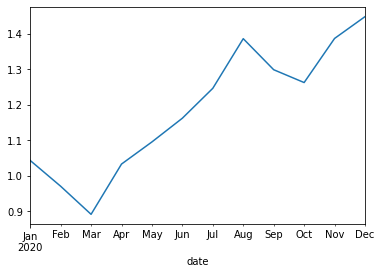

In [28]:
tech_retw = tech.groupby('date').apply(lambda x:
                                       np.average(x['retadj'], 
                                                  weights = x['melag']))
(1+tech_retw).cumprod().plot()

#### TECH equal weighted returns

<AxesSubplot:xlabel='date'>

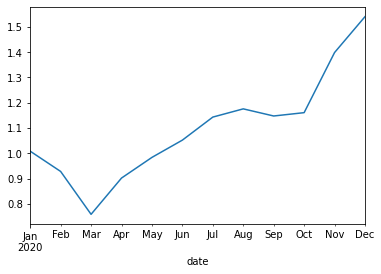

In [35]:
(1+tech.groupby('date').retadj.mean()).cumprod().plot()

### Top 10 Stocks -- CRSP

In [36]:
crsp.loc[crsp['date'] == '2020-12-31', ['comnam', 'cum_ret']].sort_values(by='cum_ret', ascending=False).head(10)

comnam    cum_ret
98849                  NOVAVAX INC  28.017587
95560            BLINK CHARGING CO  22.983871
97959                   VAXART INC  16.291015
96340                  BEAM GLOBAL  15.832618
100586         RIOT BLOCKCHAIN INC  15.169643
93659         CARDIFF ONCOLOGY INC  14.508064
99664                KIRKLANDS INC  14.419354
94274   AGEAGLE AERIAL SYSTEMS INC  13.333335
95588                  GENPREX INC  12.968751
94321    MARATHON PATENT GROUP INC  11.844793

Top 10 performing stocks in CRSP are BIOTECH stocks

#### Top 10 Stocks -- TECH

In [25]:
tech.loc[tech['date'] == '2020-12-31', ['comnam', 'cum_ret']].sort_values(by='cum_ret', ascending=False).head(10)

comnam   cum_ret
182649  UNIVERSAL SECURITY INSTRS INC  8.080646
183529            DIGITAL TURBINE INC  7.932679
182999             MICROVISION INC WA  7.472223
182456                     KOPIN CORP  6.058340
183415                    EMAGIN CORP  4.799302
183034             D P W HOLDINGS INC  4.677419
182642                   INNODATA INC  4.649123
178558                     VUZIX CORP  4.517413
184285  C B A K ENERGY TECHNOLOGY INC  4.400000
180420                     FASTLY INC  4.353264

## Q3 -- OPBE Sorts

#### Download Compustat in 2020

In [26]:
fund_table = 'funda'

varlist = ['conm', 'tic', 'cusip','fyear', 'fyr', 'at','capx', 'ceq', 'cogs', 'csho', 'dlc', 'dlcch','dltt', 'dp', 'ib', 'itcb', 
           'lt', 'mib', 'naicsh', 'ni', 'prstkcc', 'pstk', 'pstkl', 'pstkrv', 're', 'revt', 'sale', 
           'seq', 'sich', 'txdb', 'txdi', 'txditc', 'wcapch', 'xint', 'xlr', 'xrd', 'xsga']


query = """SELECT gvkey, datadate, {}
           FROM comp.{}
           WHERE datafmt = 'STD'
           AND popsrc = 'D'
           AND indfmt = 'INDL'
           AND consol = 'C'
           AND fyear>=2020;""".format(", ".join(varlist), fund_table)

compa = db.raw_sql(query, date_cols=['datadate'])

#### Keep the latest (datadate) obervation if there are duplicates

In [27]:
# How to deal with duplicates? Keep last available entry (datadate)
compa.dropna(subset=['fyear'], inplace=True)
compa.sort_values(['gvkey','fyear','at'], inplace=True)
compa = compa[~compa.duplicated(['gvkey', 'fyear'], keep='first')]
assert compa.duplicated(['gvkey', 'fyear']).sum() == 0

#### Calculate OPBE

In [28]:
#%% Calculating BE

# Shareholder Equity
compa['se'] = compa['seq']

# Uses Common Equity (ceq) + Preferred Stock (pstk) if SEQ is missing:
compa['se'].fillna((compa['ceq'] + compa['pstk']), inplace=True)

# Uses Total Assets (at) - Liabilities (lt) + Minority Interest (mib, if available), if others are missing
compa['se'].fillna((compa['at'] - compa['lt'] + compa['mib'].fillna(0)), inplace=True)

# Preferred Stock
# Preferred Stock (Redemption Value)
compa['ps'] = compa['pstkrv']
# Uses Preferred Stock (Liquidating Value (pstkl)) if Preferred Stock (Redemption Value) is missing
compa['ps'].fillna(compa['pstkl'], inplace=True)
# Uses Preferred Stock (Carrying Value (pstk)) if others are missing
compa['ps'].fillna(compa['pstk'], inplace=True)

# Deferred Taxes
# Uses Deferred Taxes and Investment Tax Credit (txditc)
compa['dt'] = compa['txditc']

# This was Novy-Marx old legacy code. We drop this part to be in accordance with Ken French.
# Uses Deferred Taxes and Investment Tax Credit(txdb) + Investment Tax Credit (Balance Sheet) (itcb) if txditc is missing
compa['dt'].fillna((compa['txdb'].fillna(0) + compa['itcb'].fillna(0)), inplace=True)
# If all measures are missing, set n  to missing
compa.loc[pd.isnull(compa['txditc']) & pd.isnull(compa['txdb']) & pd.isnull(compa['itcb']), 'dt'] = np.nan

compa.loc[compa['fyear'] >= 1993, 'dt'] = 0

# Book Equity
# Book Equity (BE) = Share Equity (se) - Prefered Stocks (ps) + Deferred Taxes (dt)
compa['be'] = (compa['se']  # shareholder equity must be available, otherwise BE is missing
               - compa['ps']  # preferred stock must be available, otherwise BE is missing
               + compa['dt'].fillna(0))  # add deferred taxes if available
               #- compa['prba'].fillna(0))  # subtract postretirement benefit assets if available

In [29]:
# COST = COGS + XSGA + XINT 
compa['cost'] = compa[['cogs', 'xsga', 'xint']].sum(axis=1, skipna=True)
compa.loc[compa[['cogs', 'xsga', 'xint']].isnull().all(axis=1), 'cost'] = np.nan

# OP = SALE -COST    
compa['op'] = compa['sale']-compa['cost']

# Calculate OPBE
compa.loc[(compa.be > 0), 'opbe'] = compa['op']/compa['be']

#### Merge

In [30]:
sql = '''SELECT gvkey, lpermno as permno, lpermco as permco, linktype, linkdt, linkenddt
         FROM crsp.ccmxpf_lnkhist
         WHERE linktype IN ('LC', 'LU', 'LS') 
      ''' 

link_table = db.raw_sql(sql, date_cols=['linkdt', 'linkenddt'])

In [31]:
df = pd.merge(compa, link_table, on=['gvkey'], how='inner') 
df = df[(df.datadate >= df.linkdt) | (df.linkdt.isnull())]
df = df[(df.datadate <= df.linkenddt) | (df.linkenddt.isnull())]

In [32]:
tech = tech.merge(df[['permno', 'opbe']], on='permno', how='left')
print('{} of tech stocks matched to Compustat'.format(1 - (tech['opbe'].isna().sum() / len(tech))))

0.739833936555248 of tech stocks matched to Compustat


In [33]:
tech.loc[tech['date'] == '2020-12-31', ['comnam', 'opbe']].sort_values(by='opbe', ascending=False).head(10)

comnam      opbe
2951                CITRIX SYSTEMS INC  6.098481
1202             DELL TECHNOLOGIES INC  4.352965
2939                       WATERS CORP  3.295803
1439                  PITNEY BOWES INC  3.027592
3410  METTLER TOLEDO INTERNATIONAL INC  2.985305
1059               AVAYA HOLDINGS CORP  1.677966
4379                    MASTERCARD INC  1.307151
1415   AEROJET ROCKETDYNE HOLDINGS INC  1.221413
654                          APPLE INC  1.139763
183                    FAIR ISAAC CORP  0.994279

These are not the same as the top 10s in Q2